Code written by Barbara Morales and Dr. Michael Shirts to analyze harmonic potential method calculation and simulation results of osmotic coefficients.

We  attempt to use a different approach, the maximum likelihood fitting, to replicate the harmonic potential analysis done by Hank Ashbaugh and Alireza Hosseni, who used least-squares fitting.

Equations and variables are referenced from their article in the following link: https://pubs.acs.org/doi/10.1021/acs.jctc.3c00982

# Imports

In [1]:
import logging
logging.basicConfig(
    level=logging.INFO
)

import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import numpy as np
import pandas as pd
import math
import json
import csv


import matplotlib.pyplot as plt

from scipy.optimize import least_squares, minimize
from scipy.integrate import simpson
from scipy.integrate import quad, simpson, trapezoid
from timeit import default_timer as timer


from openmm.unit import bar, mole, litre, kelvin, kilojoule, kilojoule_per_mole, nanometer, angstrom, kilocalorie_per_mole, kilogram, molar, atmosphere, nanosecond, picosecond, femtoseconds
from openmm.unit import Quantity, Unit
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

import MDAnalysis as mda
import sys
sys.path.append('..')  # one level up
from salt_data import SaltData, salt_infos

INFO:numexpr.utils:NumExpr defaulting to 16 threads.


# Inputs

## Defining variables and constants

In [2]:
k : Quantity=0.68*(kilojoule/mole/nanometer**2)

L_x, L_y, L_z = 4.8, 4.8, 14.4  # lengths in x,y and z caluations
T = 300  # units: K - temperature used for calculations

z_center : Quantity=7.2 * nanometer
delta_z : Quantity=2.4 * nanometer,

NA = 6.02214076E23  # Avogadro's number
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant

## Specify simulation/experiment details

In [3]:
ion1="Mg" # Use actual name of cation, with capital letters and lower case 
ion2="Cl" # Use actual name of anion, with capital letters and lower case 
center_atom1='Mg' # Use actual name of cation, with capital letters and lower case. If polyatomic, specify the ion in the center of the molecule (e.g., for Na use 'Na', for NH4 use 'N') 
center_atom2='Cl' # Use actual name of cation, with capital letters and lower case. If polyatomic, specify the ion in the center of the molecule (e.g., for Cl or Cl2 use 'Cl', for NO3 use 'N') 
water='OPC3' # Specify water model used for labelling purposes and for choosing directory of inputs and outputs 
ff_used = f'Sage 2.1 + {water}' # Specify name of force field used for experiment 
vantHoff=2 # Specify van't Hoff factor of salt (e.g., NaCl uses 2, MgCl2 uses 3)
N_replicates=6 # Specify number of replicates to be analyzed or less if desired
molalities=[0.5] # Specify molalities to be analyzed (should be just one, the attempted max concentration, for harmonic potentials)

## Load salt information

In [4]:
def load_salt_info(ion1, ion2):
    """
    Load all data entries for a specific salt from salt_info and return them as a dictionary
    where the salt appears only once with a subdictionary containing all its data.
    """
    salt = ion1 + ion2
    print(f"Salt to be analyzed: {salt}")

    # Convert dictionaries into SaltData instances
    salt_info_cleaned = [SaltData(**entry) if isinstance(entry, dict) else entry for entry in salt_infos]

    # Filter all entries that match the requested salt and store in a subdictionary
    filtered_entries = {
        f"Molality {entry.molality} mol/kg": {
            "Molarity": entry.molarity,
            "Number of Particles": math.ceil(entry.num_particles),
            "Osmotic Coefficient": entry.osmotic_coefficient,
        }
        for entry in salt_info_cleaned if entry.salt == salt
    }

    # Return results with the salt name as the top-level key
    if filtered_entries:
        return {salt: filtered_entries}
    else:
        return {"Error": f"No data found for {salt}"}


In [5]:
salt_dict=load_salt_info(ion1,ion2)
print(salt_dict)
resname_ions=(ion1+" "+ion2).upper()

wdir = Path(f'HP_{ion1}{ion2}_{water}')
wdir.mkdir(exist_ok=True)

rdir = Path(f'{wdir}/result_files')
# rdir.mkdir(exist_ok=True)

Salt to be analyzed: MgCl
{'MgCl': {'Molality 0.1 mol/kg': {'Molarity': 0.1, 'Number of Particles': 7, 'Osmotic Coefficient': 0.861}, 'Molality 0.2 mol/kg': {'Molarity': 0.199, 'Number of Particles': 14, 'Osmotic Coefficient': 0.877}, 'Molality 0.3 mol/kg': {'Molarity': 0.297, 'Number of Particles': 20, 'Osmotic Coefficient': 0.895}, 'Molality 0.4 mol/kg': {'Molarity': 0.395, 'Number of Particles': 27, 'Osmotic Coefficient': 0.919}, 'Molality 0.5 mol/kg': {'Molarity': 0.494, 'Number of Particles': 34, 'Osmotic Coefficient': 0.947}, 'Molality 0.6 mol/kg': {'Molarity': 0.591, 'Number of Particles': 40, 'Osmotic Coefficient': 0.976}, 'Molality 0.7 mol/kg': {'Molarity': 0.69, 'Number of Particles': 47, 'Osmotic Coefficient': 1.004}, 'Molality 0.8 mol/kg': {'Molarity': 0.786, 'Number of Particles': 54, 'Osmotic Coefficient': 1.036}, 'Molality 0.9 mol/kg': {'Molarity': 0.882, 'Number of Particles': 60, 'Osmotic Coefficient': 1.071}, 'Molality 1.0 mol/kg': {'Molarity': 0.977, 'Number of Parti

# ANALYSIS

## Functions

In [6]:
def extract_experiment_data(data, salt):
    """
    Extracts molarity values and their corresponding osmotic coefficients
    for a given salt and stores them in two separate lists.
    
    Parameters:
        data (dict): The dictionary containing salt data.
        salt (str): The name of the salt (e.g., "NaCl").

    Returns:
        molarity_list (list): List of molarity values.
        osmotic_coeff_list (list): List of corresponding osmotic coefficients.
    """
    molarity_list = []
    osmotic_coeff_list = []

    if salt in data:
        for molality_key, values in data[salt].items():
            molarity_list.append(values["Molarity"])
            osmotic_coeff_list.append(values["Osmotic Coefficient"])
    else:
        print(f"Salt '{salt}' not found in data.")

    return molarity_list, osmotic_coeff_list

In [7]:
def osm_experimental(exp_osm_coeff: float, vant_hoff: int = vantHoff, molarity: Quantity = 1*(mole/litre), T = 300*kelvin):
    R = 0.08314 * bar * litre / (mole * kelvin)  # Ideal gas constant in bar·L/(mol·K)
    
    # Convert molarity to compatible units
    molarity = molarity.in_units_of(mole / litre)
    
    # Calculate ideal osmotic pressure
    osm_press_ideal = vant_hoff * molarity * R * T
    
    # Convert osmotic pressure to bar
    osm_press_ideal = osm_press_ideal.in_units_of(bar)
    
    # Apply experimental coefficient
    osm_bar = exp_osm_coeff * osm_press_ideal
    
    # Calculate error
    op_error = (abs(osm_bar - osm_press_ideal) / osm_press_ideal) * 100
    
    # Print values if needed
    # print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentration {molarity}')
    # print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    
    return osm_bar

In [8]:
def osmotic_pressure(cs, params, nu=vantHoff):
    """
    Function to calculate osmotic pressure and osmotic coefficients from the parameters
    """
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4) # osmotic pressure
    op=p/100 # osmotic pressure in units of bar
    ip = nu*R*T*cs  # ideal osmotic pressure
    return op,p/ip # osmotic pressure, osmotic coefficient

In [9]:
def find_closest(lst, target):
    '''
    Function that finds the closest index from the concentration list, given a target concentration value
    '''
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    closest_value = lst[closest_index]
    return closest_index, closest_value

In [10]:
def format_dict(obj):
    '''Function that formats the decimals of the values in dictionary recursively'''
    if isinstance(obj, dict):
        return {k: format_dict(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [format_dict(v) for v in obj]
    elif isinstance(obj, float):
        return round(obj, 3)
    else:
        return obj

In [11]:
def get_ion_array(u,ions):
    '''
    Function to get array of ion's z coordinate positions throughout trajectory of all samples.
    '''
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array)-72)/10  # rescale the data, setting the half of the length of the box to zero
    zvals=ionz.flatten()
    return zvals

In [12]:
def count_profile_z_fixed_Lz(u, ag, dz_nm=0.05):
    """
    Time-averaged *counts* profile along z for a fixed Lz (from first frame).
    Returns: z_centers (nm), bin_widths (nm), avg_counts (ions/bin)
    """
    Lz_nm = u.trajectory.ts.dimensions[2] / 10.0
    edges = np.arange(-Lz_nm/2, Lz_nm/2 + dz_nm, dz_nm)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)

    counts_accum = np.zeros_like(centers, dtype=float)
    n_frames = 0
    for ts in u.trajectory:
        mid = Lz_nm / 2.0
        z_nm = ag.positions[:, 2] / 10.0 - mid  # Å→nm and center
        counts, _ = np.histogram(z_nm, bins=edges)
        counts_accum += counts
        n_frames += 1

    avg_counts = counts_accum / max(n_frames, 1)
    return centers, widths, avg_counts

def molarity_profile_fixed_Lz(u, ag, dz_nm=0.05):
    """
    Time-averaged molarity profile (mol/L) on the same fixed-Lz grid as counts.
    Important: average the per-frame molarity, not counts-then-divide.
    Returns: z_centers (nm), c_mean (mol/L)
    """
    Lz_nm = u.trajectory.ts.dimensions[2] / 10.0
    edges = np.arange(-Lz_nm/2, Lz_nm/2 + dz_nm, dz_nm)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths  = np.diff(edges)

    c_accum = np.zeros_like(centers, dtype=float)
    n_frames = 0
    for ts in u.trajectory:
        # Box in nm (ts.dimensions is Å)
        Lx_nm, Ly_nm, Lz_nm_frame = ts.dimensions[:3] / 10.0
        mid = Lz_nm / 2.0  # keep same fixed-Lz centering
        z_nm = ag.positions[:, 2] / 10.0 - mid
        counts, _ = np.histogram(z_nm, bins=edges)

        # per-bin volume (L) for THIS frame
        bin_vol_L = (Lx_nm * Ly_nm) * widths * 1e-24  # nm^3 -> L
        with np.errstate(divide='ignore', invalid='ignore'):
            c_frame = (counts / NA) / bin_vol_L  # mol/L (piecewise-constant)
            c_frame[~np.isfinite(c_frame)] = 0.0

        c_accum += c_frame
        n_frames += 1

    c_mean = c_accum / max(n_frames, 1)
    return centers, c_mean

def fold_profile(z, y):
    """
    Fold symmetric profile around z=0 to keep only z>=0.
    Works for counts and molarity.
    """
    n = len(z)
    half = n // 2
    if n % 2 == 0:
        y_pos = 0.5 * (y[:half][::-1] + y[half:])
        z_pos = z[half:]
    else:
        center = y[half]
        left = y[:half][::-1]
        right = y[half+1:]
        avg = 0.5 * (left + right)
        y_pos = np.concatenate(([center], avg))
        z_pos = z[half:]
    return z_pos, y_pos

### Calculating eq 12

$$ \ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [13]:
if vantHoff == 2:
    A = 1.7964  # in M^(-1/2), value based on Debye Huckel equations. Taken from reference source.
elif vantHoff == 3: 
    A= 2.50 # in M^(-1/2), value based on Debye Huckel equations. Recalculated.

print(A)
# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

1.7964


In [14]:
def calc_y(theta, x):
    '''
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    '''

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1] * (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

## Load data

### Experimental data

In [15]:
# Experimental values of osmotic coefficient obtained from Hamer & Wu paper
exp_concs, yexpOC = extract_experiment_data(salt_dict,f"{ion1}{ion2}")
print(exp_concs)
# Convert quantities to scalars in appropriate units for plotting
exp_concs_values = [x*(molar) for x in exp_concs]

# Experimental values of osmotic pressure obtained from Hamer & Wu paper
yexpOP=[]
for i,m in enumerate(exp_concs):
    op_res=osm_experimental(exp_osm_coeff=yexpOC[i], vant_hoff=vantHoff, molarity=exp_concs_values[i])
    yexpOP.append(op_res.value_in_unit(op_res.unit))

[0.1, 0.199, 0.297, 0.395, 0.494, 0.591, 0.69, 0.786, 0.882, 0.977, 1.169, 1.356, 1.54, 1.911, 2.348, 2.768, 3.197, 3.692, 4.022]


### Simulation data

In [16]:
us = {}
ions = {}

# Load trajectories and ion selections
for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}" # '1' or '0.5'
        mi = str(int(mol))
    else:
        mi = f"{mol:.1f}".replace('.', '') # '0.5' → '05'
        mi1 = f"{mol:.1f}"

    us[mi] = []
    ions[mi] = []

    for i in range(N_replicates):
        postfix = f'{mi}m_r{i}'
        frdir = f'{rdir}_{mi}m'
        pdb = f'md{postfix}.pdb'
        xtc = f'md{postfix}.xtc'
        u = mda.Universe(os.path.join(frdir, pdb), os.path.join(frdir, xtc))
        u.transfer_to_memory()

        us[mi].append(u)
        
        # Creating a subgroup of ions
        if center_atom1 != center_atom2:
            ions[mi].append(u.select_atoms(f'element {center_atom1}', f'element {center_atom2}'))
        else:
            ions[mi].append(u.select_atoms(f'element {center_atom1}'))


INFO:MDAnalysis.core.universe:The attribute(s) types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
INFO:MDAnalysis.core.universe:The attribute(s) types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.core.universe:attribute masses has been guessed successful

## Concentration Profiles

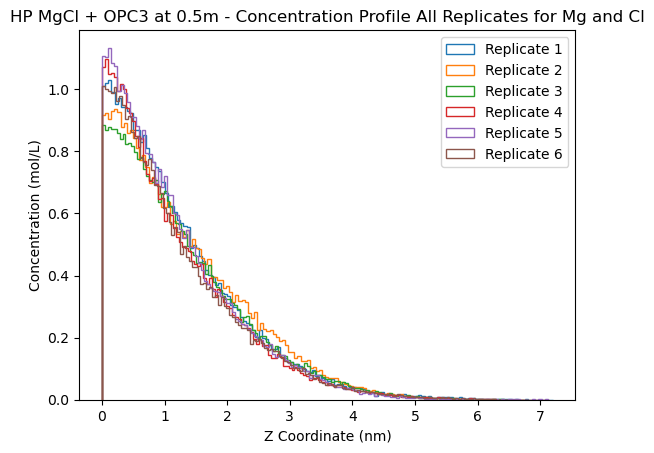

In [17]:
zvals = list()
concentration_profiles = []
zreps = []

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'
    N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']
    frdir = f'{rdir}_{mi}m'

    for i in range(N_replicates):
        zvals_i = get_ion_array(us[mi][i], ions[mi][i])
        zvals.append(zvals_i)

        concs, bins, _ = plt.hist(
            zvals_i,
            bins=int(L_z * 10),
            weights=np.full_like(zvals_i, N_i / zvals_i.size),
            histtype='step',
            label=f"Replicate {i+1}"
        )
        concentration_profiles.append(concs)
        zreps.append(0.5 * (bins[1:] + bins[:-1]))

        plt.title(f'HP {ion1}{ion2} + {water} at {mi1}m - Concentration Profile All Replicates for {ion1} and {ion2}')
        plt.xlabel('Z Coordinate (nm)')
        plt.ylabel('Concentration (mol/L)')

    plt.legend()
    plt.savefig(f'{frdir}/conc_prof_allreps_{ion1}{ion2}.png')
    
    plt.show()

# Convert to NumPy arrays
concentration_profiles = np.array(concentration_profiles)
zreps = np.array(zreps)

zvals_all = np.array(zvals).flatten()

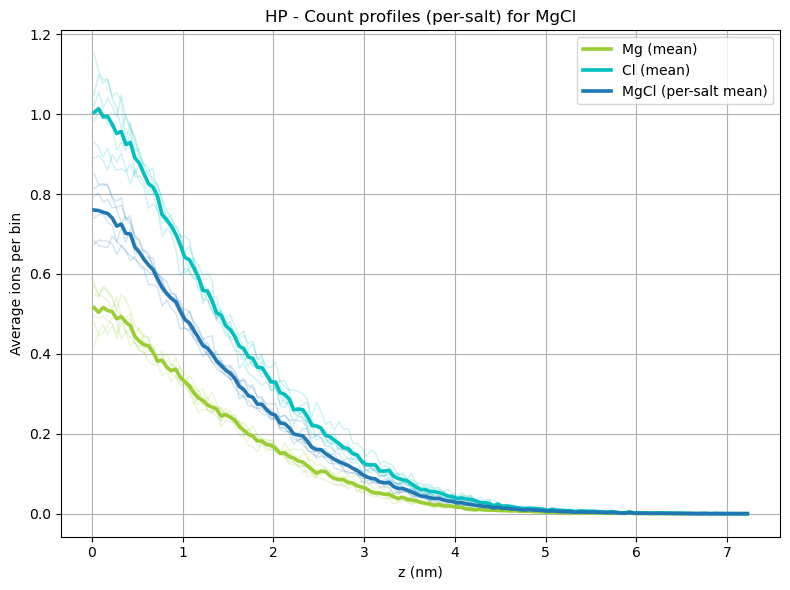

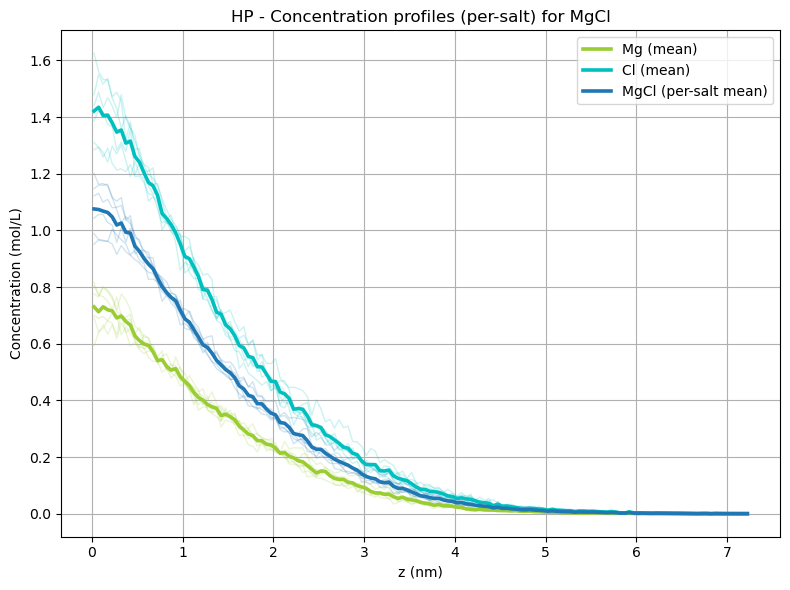

Rep 0: ion1=33, ion2=66, Pairs=33
Rep 1: ion1=33, ion2=66, Pairs=33
Rep 2: ion1=33, ion2=66, Pairs=33
Rep 3: ion1=33, ion2=66, Pairs=33
Rep 4: ion1=33, ion2=66, Pairs=33
Rep 5: ion1=33, ion2=66, Pairs=33
Approx ions/frame from folded per-salt counts (rep-mean): ~50.26


In [18]:
# ===================== RUN (build both: counts & molarity) =====================

dz_nm = 0.05  # bin thickness (nm)

# per-replicate lists
z_ion1_cnt, ion1_cnt = [], []
z_ion2_cnt, ion2_cnt = [], []
z_salt_cnt, salt_cnt = [], []  # per-salt = 0.5 * (ion1 + ion2)

z_ion1_M, ion1_M = [], []
z_ion2_M, ion2_M = [], []
z_salt_M, salt_M = [], []

Ns_ion1_list, Ns_ion2_list, Ns_pairs_list = [], [], []

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi  = str(int(mol))      # '1'
    else:
        mi  = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'

    frdir = f'{rdir}_{mi}m'

    for u in us[mi]:
        ag1 = u.select_atoms(f'element {center_atom1}')
        ag2 = u.select_atoms(f'element {center_atom2}')

        # --- counts/bin (fixed-Lz) ---
        z1, w1, cts1 = count_profile_z_fixed_Lz(u, ag1, dz_nm)
        z2, w2, cts2 = count_profile_z_fixed_Lz(u, ag2, dz_nm)
        z_ion1_cnt.append(z1); ion1_cnt.append(cts1)
        z_ion2_cnt.append(z2); ion2_cnt.append(cts2)
        z_salt_cnt.append(z1); salt_cnt.append(0.5 * (cts1 + cts2))  # per-salt average

        # --- molarity (mol/L) on same fixed-Lz grid ---
        z1M, c1M = molarity_profile_fixed_Lz(u, ag1, dz_nm)
        z2M, c2M = molarity_profile_fixed_Lz(u, ag2, dz_nm)
        z_ion1_M.append(z1M); ion1_M.append(c1M)
        z_ion2_M.append(z2M); ion2_M.append(c2M)
        z_salt_M.append(z1M);  salt_M.append(0.5 * (c1M + c2M))      # per-salt average

        # exact counts from topology
        Ns_ion1_list.append(ag1.n_atoms)
        Ns_ion2_list.append(ag2.n_atoms)
        Ns_pairs_list.append(min(ag1.n_atoms, ag2.n_atoms))

# ===== Fold to positive z, stack, and replicate means =====

def fold_stack(z_list, y_list):
    folded = [fold_profile(z, y) for z, y in zip(z_list, y_list)]
    zpos = folded[0][0]
    stack = np.vstack([yf for _, yf in folded])
    return zpos, stack, stack.mean(axis=0)

# counts/bin (per-salt average)
zpos_cnt_1, stack_cnt_1, mean_cnt_1 = fold_stack(z_ion1_cnt, ion1_cnt)
zpos_cnt_2, stack_cnt_2, mean_cnt_2 = fold_stack(z_ion2_cnt, ion2_cnt)
zpos_cnt_s, stack_cnt_s, mean_cnt_s = fold_stack(z_salt_cnt, salt_cnt)

# molarity (mol/L, per-salt average)
zpos_M_1, stack_M_1, mean_M_1 = fold_stack(z_ion1_M,  ion1_M)
zpos_M_2, stack_M_2, mean_M_2 = fold_stack(z_ion2_M,  ion2_M)
zpos_M_s, stack_M_s, mean_M_s = fold_stack(z_salt_M,  salt_M)

# ===================== PLOT 1: Average ions per bin =====================

plt.figure(figsize=(8,6))
for y in stack_cnt_1: plt.plot(zpos_cnt_1, y, alpha=0.2, lw=1, color='yellowgreen')
for y in stack_cnt_2: plt.plot(zpos_cnt_2, y, alpha=0.2, lw=1, color='c')
for y in stack_cnt_s: plt.plot(zpos_cnt_s, y, alpha=0.2, lw=1, color='tab:blue')

plt.plot(zpos_cnt_1, mean_cnt_1, lw=2.6, color='yellowgreen', label=f"{ion1} (mean)")
plt.plot(zpos_cnt_2, mean_cnt_2, lw=2.6, color='c',            label=f"{ion2} (mean)")
plt.plot(zpos_cnt_s, mean_cnt_s, lw=2.6, color='tab:blue',     label=f"{ion1}{ion2} (per-salt mean)")

plt.xlabel("z (nm)")
plt.ylabel("Average ions per bin")
plt.title(f"HP - Count profiles (per-salt) for {ion1}{ion2}")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f'{frdir}/countsprof_{ion1}{ion2}.png', dpi=300)
plt.show()

# ===================== PLOT 2: Molar concentration (mol/L) =====================

plt.figure(figsize=(8,6))
for y in stack_M_1: plt.plot(zpos_M_1, y, alpha=0.2, lw=1, color='yellowgreen')
for y in stack_M_2: plt.plot(zpos_M_2, y, alpha=0.2, lw=1, color='c')
for y in stack_M_s: plt.plot(zpos_M_s, y, alpha=0.2, lw=1, color='tab:blue')

plt.plot(zpos_M_1, mean_M_1, lw=2.6, color='yellowgreen', label=f"{ion1} (mean)")
plt.plot(zpos_M_2, mean_M_2, lw=2.6, color='c',            label=f"{ion2} (mean)")
plt.plot(zpos_M_s, mean_M_s, lw=2.6, color='tab:blue',     label=f"{ion1}{ion2} (per-salt mean)")

plt.xlabel("z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.title(f"HP - Concentration profiles (per-salt) for {ion1}{ion2}")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f'{frdir}/concprof_{ion1}{ion2}.png', dpi=300)
plt.show()

# ===================== SUMMARY =====================
N_s_list=[]
for i, (Nc, Nb, Np) in enumerate(zip(Ns_ion1_list, Ns_ion2_list, Ns_pairs_list)):
    print(f"Rep {i}: ion1={Nc}, ion2={Nb}, Pairs={Np}")
    N_s_list.append(Np)

approx_total_ions = mean_cnt_s.sum() * 2  # folded -> multiply by 2
print(f"Approx ions/frame from folded per-salt counts (rep-mean): ~{approx_total_ions:.2f}")


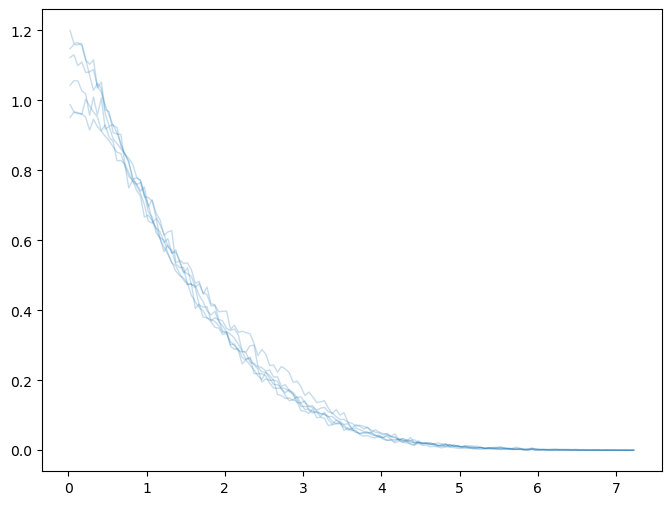

In [19]:
# --- Build from molarity profiles (per-salt), no need to loop over molalities ---
concentration_profiles_c = []   # each entry: 1 replicate profile (mol/L)
concentration_profiles_z = []   # each entry: z grid (nm), same for all reps

plt.figure(figsize=(8,6))
for y in stack_M_s:             # stack_M_s: shape (n_reps, n_bins_pos)
    plt.plot(zpos_M_s, y, alpha=0.25, lw=1, color='tab:blue')
    concentration_profiles_c.append(np.asarray(y))
    concentration_profiles_z.append(np.asarray(zpos_M_s))

# Average across replicates
c_stack = np.vstack(concentration_profiles_c)   # (n_reps, n_bins_pos)
c_0 = c_stack.mean(axis=0)                      # (n_bins_pos,)

# Folded positive-z grid
z = np.asarray(zpos_M_s)

# Mask out zeros/near-zeros or non-finite values (edges can be zero)
eps = 1e-12
mask = np.isfinite(c_0) & (c_0 > eps)
z_fit = z[mask]
c_fit = c_0[mask]


## Unweighted least squares fitting

In [20]:
initial_guess = [4,0.2,0]
# Right side/ y of equation 12
def y_values(z_fits):
    return -(0.5 * k.value_in_unit(kilojoule_per_mole/nanometer**2) * z_fits ** 2) * 1000 / (R * T) 

In [21]:
# Getting fit for full left side of eq 12
result_unweighted = least_squares(residuals, initial_guess, args=(c_fit, y_values(z_fit)))

Plot the results of the unweighted fit 

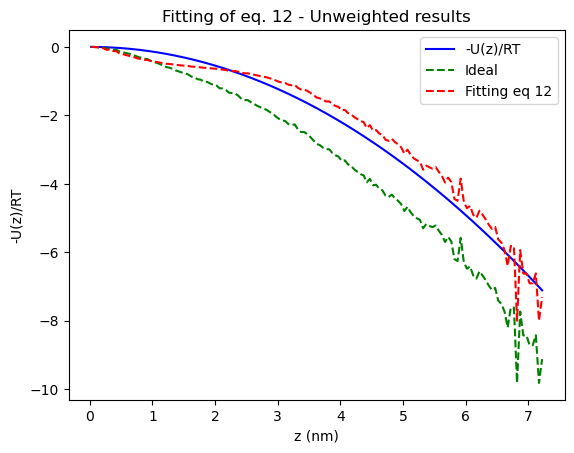

In [22]:
plt.plot(z_fit, y_values(z_fit), 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 - Unweighted results')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $|f'(x)| \delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

## Weighted least squares fitting

In [23]:
# Finding weights 
N_s=math.ceil(np.mean(N_s_list))
norm = N_s/(L_x*L_y)
print(norm)

def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(np.subtract(calc_y(theta, x),y), 2)

1.4322916666666667


In [24]:
# Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, initial_guess, args=(c_fit, y_values(z_fit)))

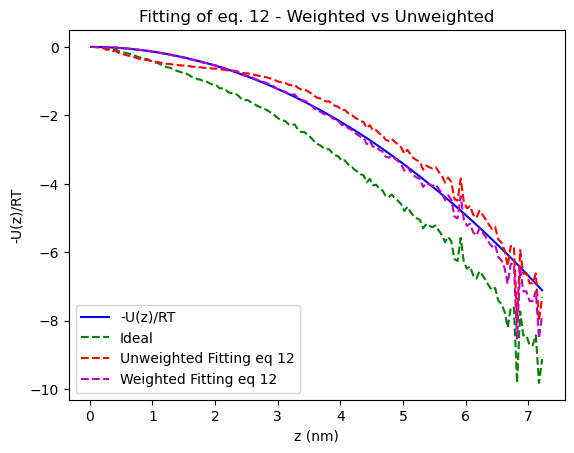

In [25]:
# plot the results
plt.plot(z_fit, y_values(z_fit), 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 - Weighted vs Unweighted')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences.

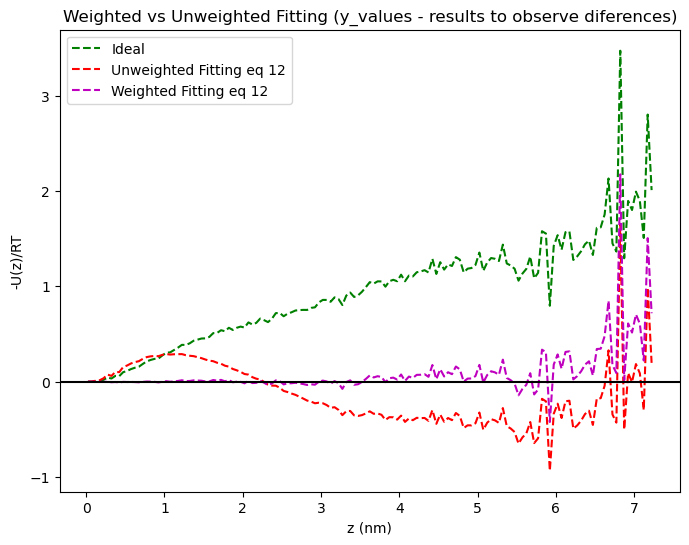

In [26]:
# Plot the results. Notice the plots are now being subtracted from the y_values results to observe differences better
plt.figure(figsize = (8,6))
plt.plot(z_fit, y_values(z_fit)-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, y_values(z_fit)-calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, y_values(z_fit)-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.axhline(y=0, color= 'k')
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Weighted vs Unweighted Fitting (y_values - results to observe diferences)')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=4.

In [27]:
# OPTIONAL: raise SystemExit("Stop here and check if zlim (coordinate limit for where fitting is closer) value has to change")

In [28]:
zlim = 4 # coordinate limit for where fitting is closer based on visual inspection of plot above

print('--- UNWEIGHTED PARAMETERS ---')
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

# Stdev of unweighted results
yv = y_values(z_fit)
stdev_uw = np.std(yv[z_fit<zlim]-calc_y(result_unweighted.x,c_fit[z_fit<zlim]))
print(f'Stdev of unweighted results: {stdev_uw}')



print('--- WEIGHTED PARAMETERS ---')
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

# Stdev of weighted results
stdev_w = np.std(yv[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))
print(f'Stdev of weighted results: {stdev_w}')

--- UNWEIGHTED PARAMETERS ---
B = 0.00032272864524850647
alpha1 = -2.0213069365652783
alpha2 = 1.5486814459477667
Stdev of unweighted results: 0.22941020312665966
--- WEIGHTED PARAMETERS ---
B = -0.0002063104468123002
alpha1 = 0.36969129455635447
alpha2 = -0.22352880127734523
Stdev of weighted results: 0.021048576145765538


Let's look at the distribution of the parameters with both types of fit.

## Bootstrapping parameters and osmotic coefficients (without and with weights)

In [29]:
trialp = initial_guess
# Function to perform bootstrapping over 4 profiles.
def bootstrap_profiles(profiles, n_samples, res_func):
    b_params = []
    b_profiles = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        result = least_squares(res_func, trialp, args=(c_fit, y_values(z_fit)))
        b_params.append(result.x)
        b_profiles.append(mean_profile)
    return np.array(b_profiles), np.array(b_params) # concentrations, and list of parameters

### Unweighted bootstrapping

Param 0 = 0.01036564132442761 +/- 0.1919815098065421


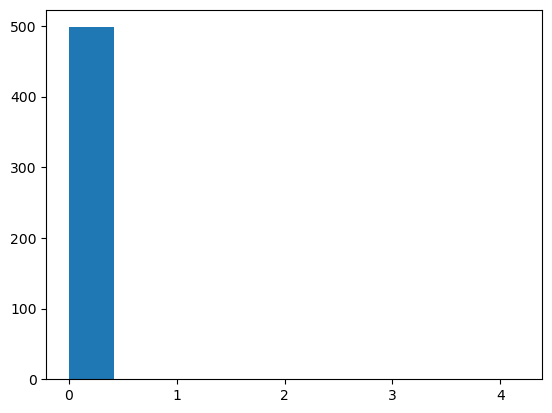

Param 1 = -1.6420577429297942 +/- 0.6331104054236154


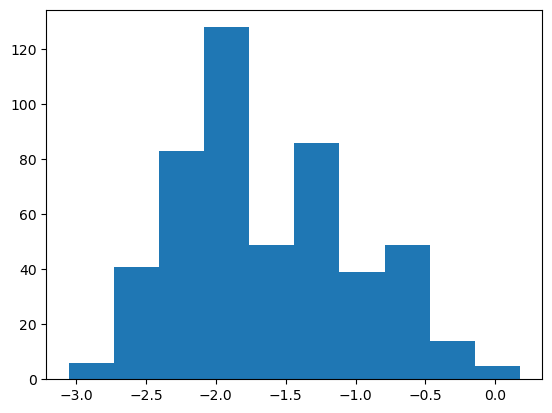

Param 2 = 1.2745974312014654 +/- 0.4978459437926701


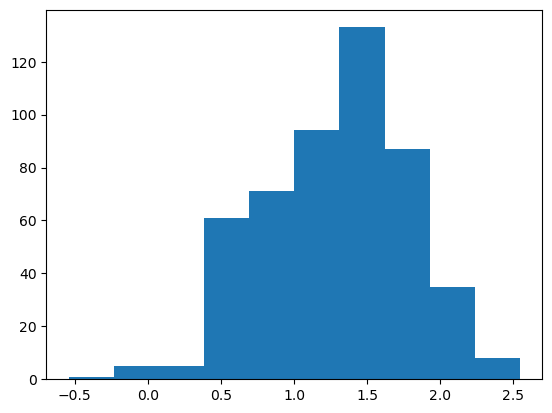

In [30]:
# Perform bootstrapping with unweighted fit
bootstrap_profiles_unweighted, bootstrap_params_unweighted = bootstrap_profiles(profiles=concentration_profiles_c, n_samples=500, res_func=residuals)
uw_bs_params=[]
for i in range(len(trialp)):
    pd = bootstrap_params_unweighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    uw_bs_params.append(mean_param)
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

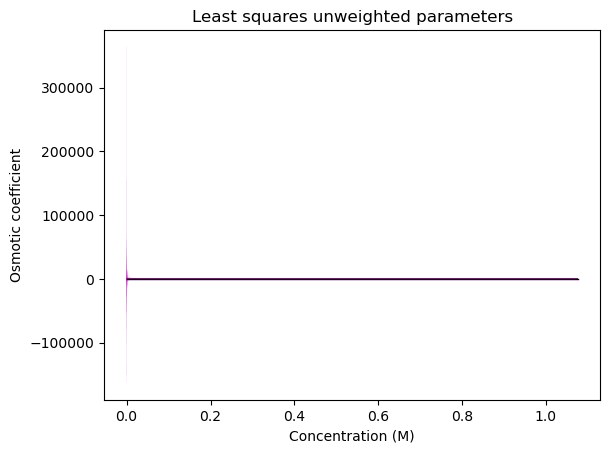

In [31]:
# Plots of the osmotic coefficients with the unweighted parameters
ops = list()
ocs = list()
for p,c in zip(bootstrap_params_unweighted, bootstrap_profiles_unweighted):
    op,oc = osmotic_pressure(c,p)
    plt.plot(c_0,oc,lw=0.1,alpha=0.2,c='m')
    ops.append(op)
    ocs.append(oc)
opt_op = osmotic_pressure(c_0,result_unweighted.x)[0]
opt_oc = osmotic_pressure(c_0,result_unweighted.x)[1]
plt.plot(c_0,opt_oc,'k',lw=1,alpha=1)
# plt.ylim([0.9,1.5])
ops = np.array(ops)
ocs = np.array(ocs)
plt.title('Least squares unweighted parameters')
plt.xlabel('Concentration (M)')
plt.ylabel('Osmotic coefficient')
plt.show()

### Weighted bootstrapping

Param 0 = 0.20409408344794316 +/- 0.5261765220429933


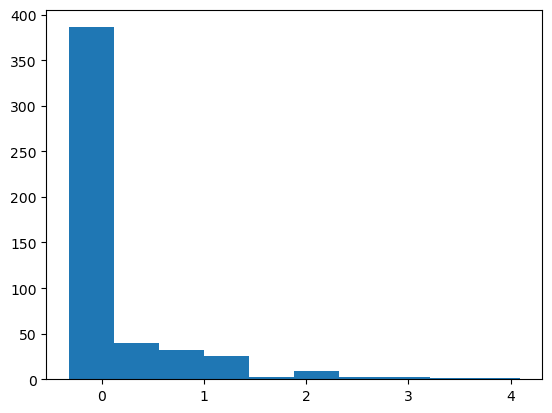

Param 1 = 0.20871040932863236 +/- 0.3767265912271928


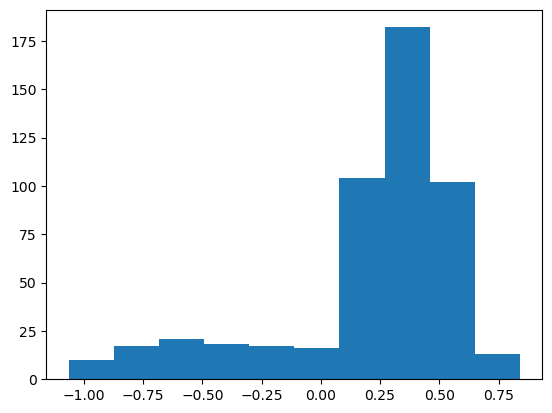

Param 2 = -0.18120369153946 +/- 0.10191022196658055


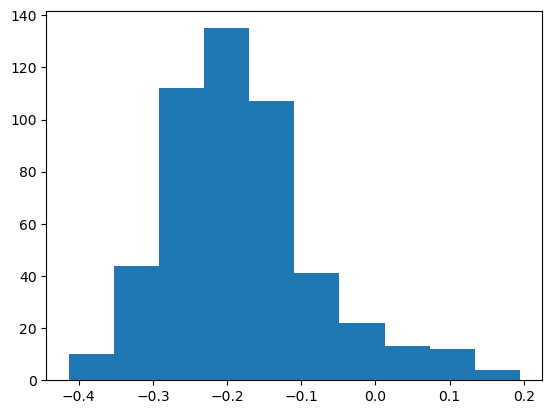

In [32]:
# Perform bootstrapping with weighted residuals
bootstrap_profiles_weighted, bootstrap_params_weighted  = bootstrap_profiles(profiles=concentration_profiles_c, n_samples=500, res_func=weighted_residuals)
w_bs_params=[]
for i in range(len(trialp)):
    pd = bootstrap_params_weighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    w_bs_params.append(mean_param)
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

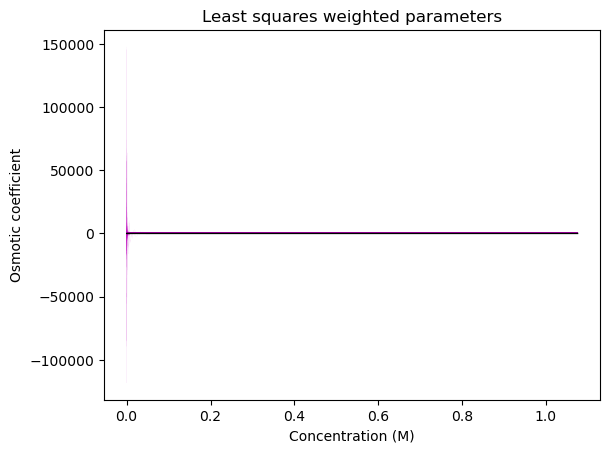

In [33]:
# Plots of the osmotic coefficients with the weighted parameters
ops = list()
ocs = list()
for p,c in zip(bootstrap_params_weighted, bootstrap_profiles_weighted):
    op,oc = osmotic_pressure(c,p)
    plt.plot(c_0,oc,lw=0.1,alpha=0.2,c='m')
    ops.append(op)
    ocs.append(oc)
opt_op = osmotic_pressure(c_0,result_weighted.x)[0]
opt_oc = osmotic_pressure(c_0,result_weighted.x)[1]
# plt.ylim([-1,2])
plt.plot(c_0,opt_oc,'k',lw=1,alpha=1)
ops = np.array(ops)
ocs = np.array(ocs)
plt.title('Least squares weighted parameters')
plt.xlabel('Concentration (M)')
plt.ylabel('Osmotic coefficient')
plt.show()

# Maximum Likelihood Parameter Optimization

The basic idea of maximum likelihood parameter optimization is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have

$P(a|x) \propto P(x|a)$.

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

## Sparse data

We can use sparse data to make a more efficient calculation, where we count how many ions were in the same coordinate /  get a sense of the how many duplicates there are at each z.

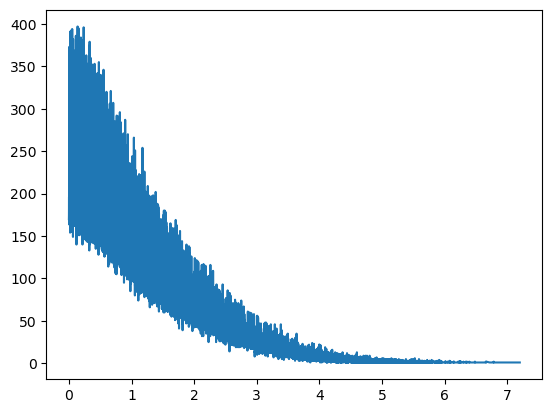

In [34]:
zsparse_o,zcount_o = np.unique(zvals_all,return_counts=True)
plt.plot(zsparse_o,zcount_o)
plt.show()

For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $z$ coordinate, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


## Normalization and maximum concentration

Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [35]:
red_U_app = lambda z: 1000*k.value_in_unit(kilojoule_per_mole/nanometer**2)*z*z/(2*R*T) # Left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

In [36]:
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k.value_in_unit(kilojoule_per_mole/nanometer**2))) # Analytical solution of normalization constant
print('Normalization constant: %.3f'%ideal_norm)

Normalization constant: 2.400


In [37]:
cmax_ideal=N_s/(L_x*L_y*ideal_norm) # Estimated maximum concentration of gradient
print('Estimated maximum concentration: %.3f M'%cmax_ideal)

Estimated maximum concentration: 0.597 M


## Calculation functions

In [38]:
def logprobfunc(a,z,cz,A=A):
    '''
    Function that calculates maximum concentration.
    '''
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [39]:
def czfunc(a,z,cz):
    '''
    Function that iterates the calculation of a concentration until it self consistently matches.
    '''
    cznew = np.exp(logprobfunc(a,z,cz))  # exponential of eq 12 for ln c/cmax for the data points
    zunique, locs = np.unique(z,return_index=True)  # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],x = zunique) # integrate
    cznorm_ratio = ideal_norm/newarea # get normalization ratio
    return (cmax_ideal*cznorm_ratio)*cznew

In [40]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):
    '''
    Function that calculates the concentration from given parameters, z coordinate list, starting concentration list.
    '''

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

In [41]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    '''
    Function that calcualtes the logarithm term, arranged as a solution to equation 12, using 
    new generated concentrations from given parameters
    '''
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [42]:
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    '''
    Function to perform bootstrapping over samples
    '''
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

## Fitting

We can use sparse data to make calculation faster since some ion z coordinates repeat multiple times throughout trajectories

In [43]:
# newp = np.array([1.35,0.33,-0.04]) # propose initial parameter guesses
newp = result_weighted.x # Define as initial guess the results of weighted least squares and bootstrapping


In [44]:
zsparse_all, zcount_all = np.unique(zvals_all,return_counts=True) # get sparse data of z coordinate list

In [45]:
c_new_sparse_all = converge_c(newp,zsparse_all,cz_start='ideal',lim=0.001,verbose=True) # get concentrations for sparse z coordinate list

0 4.25821108465572


1 1.456474754387062
2 0.6002671352540507
3 0.2724866050865405
4 0.1312194219160449
5 0.0657126145819106
6 0.03382274448866441
7 0.017761786026117322
8 0.009470609043264121
9 0.0051101901876183025
10 0.00278378254599577
11 0.0015283323805163492
12 0.0008445316455589044


In [46]:
results = minimize(neglliter,newp,args=(zsparse_all,c_new_sparse_all,zcount_all),method = 'Nelder-Mead') # minimize using sparse data
full_opt=results.x
print(full_opt)

[-0.00025762  0.21783969 -0.2469851 ]


In [47]:
c_opt_sparse_all = converge_c(full_opt,zsparse_all,cz_start=c_new_sparse_all,verbose=False) # get conventrations from minimized/optimized parameters

## Bootstrapping

In [48]:
bparams,bcs = bootstrap_samples(zvals_all, 250, neglliter, results.x) # Change number of bootstraps desired, using 500 here for better statistics.

0 [-0.00026119  0.21876987 -0.24681555] 169203.38792014314
1 [-0.0002629   0.21987172 -0.24606943] 169274.709831367
2 [-2.40987795e-04  2.31607915e-01 -2.56170459e-01] 169926.1611812335
3 [-0.00027295  0.21335907 -0.24482656] 168671.81598687725
4 [-0.00024571  0.18962423 -0.22197668] 168460.6611674447
5 [-0.00025692  0.20701366 -0.23626883] 169033.3706006285
6 [-0.00026352  0.21885822 -0.24726974] 169028.9425426358
7 [-0.0002649   0.20946371 -0.2399563 ] 168257.17276303418
8 [-2.30136300e-04  2.27258383e-01 -2.54959402e-01] 169016.7136083602
9 [-2.26844846e-04  2.29382148e-01 -2.56570227e-01] 169024.65945228178
10 [-2.37937326e-04  2.34528740e-01 -2.58326020e-01] 169647.40138197082
11 [-0.00026284  0.21939821 -0.24682697] 169438.7417960795
12 [-0.00028848  0.20416042 -0.23810195] 167919.45219645265
13 [-0.00026258  0.21826995 -0.24971866] 168256.52576098975
14 [-0.00027981  0.21460288 -0.24464868] 168917.26778999437
15 [-4.26847431e-05  1.93740653e-01 -2.24180634e-01] 168677.5387275016

### Results Statistics

B: parameter 0

$\alpha_1$: parameter 1

$\alpha_2$: parameter 2

In [49]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
# print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.          0.47819777 -0.4488816 ]
 [ 0.47819777  1.         -0.98877198]
 [-0.4488816  -0.98877198  1.        ]]


Parameter 0 = -0.0002607732243425362 +/- 4.3920608235451527e-05


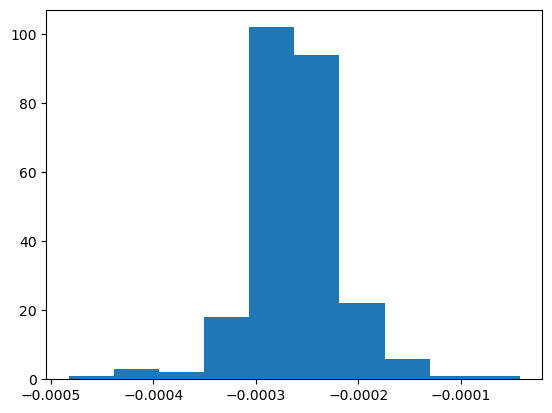

Parameter 1 = 0.21756314212248576 +/- 0.012765369833563406


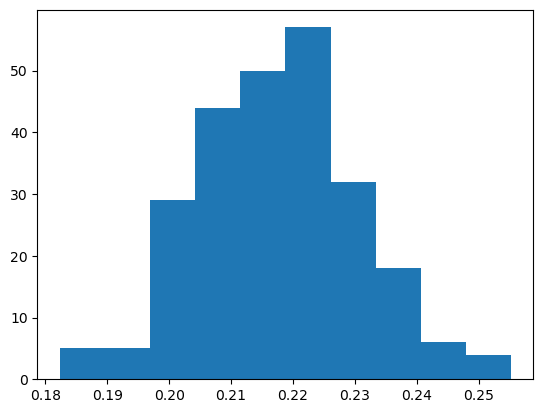

Parameter 2 = -0.24661370672741162 +/- 0.010627721214495995


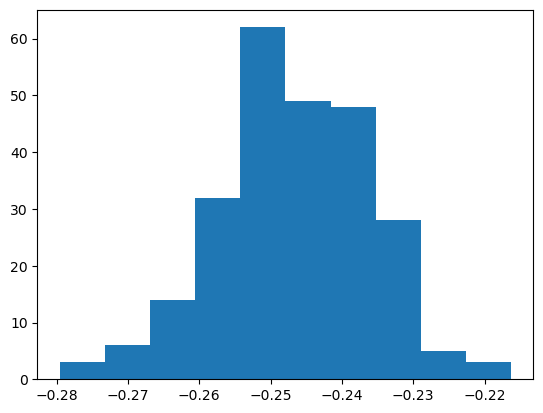

In [50]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd)
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parameter {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

In [51]:
def scatplots(bparams, bcs, c_opt_sparse_all, full_opt, author):
    '''
    Function that calculates the osmotic coefficients and osmotic pressures
    for input concentrations and parameters, then plots each property
    separately in a scatter plot with overlaid predictions.
    '''
    ops = []
    ocs = []

    for p, c in zip(bparams, bcs):
        op, oc = osmotic_pressure(c, p)
        ops.append(op)
        ocs.append(oc)

    ops = np.array(ops)
    ocs = np.array(ocs)

    opt_op, opt_oc = osmotic_pressure(c_opt_sparse_all, full_opt)

    # --- Plot osmotic coefficients ---
    plt.figure(figsize=(6, 4))
    for c, oc in zip(bcs, ocs):
        plt.scatter(c, oc, s=1, alpha=0.1, color='m', label=None)
    plt.plot(c_opt_sparse_all, opt_oc, 'k', lw=1.5, label='Model fit')
    plt.title(f'Osmotic Coefficients - {author}')
    plt.xlabel('Concentration (M)')
    plt.ylabel('Osmotic Coefficient')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot osmotic pressures ---
    plt.figure(figsize=(6, 4))
    for c, op in zip(bcs, ops):
        plt.scatter(c, op, s=1, alpha=0.1, color='b', label=None)
    plt.plot(c_opt_sparse_all, opt_op, 'k', lw=1.5, label='Model fit')
    plt.title(f'Osmotic Pressures - {author}')
    plt.xlabel('Concentration (M)')
    plt.ylabel('Osmotic Pressure (bar)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ocs, ops, opt_oc, opt_op

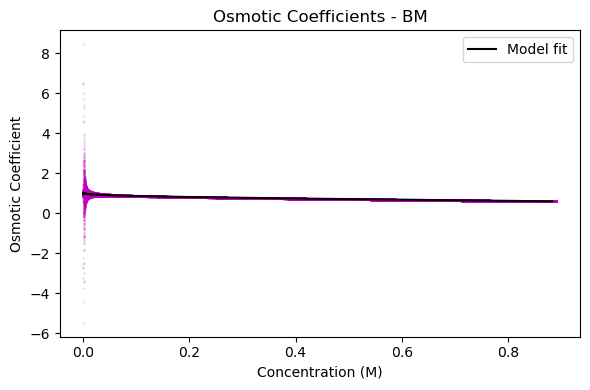

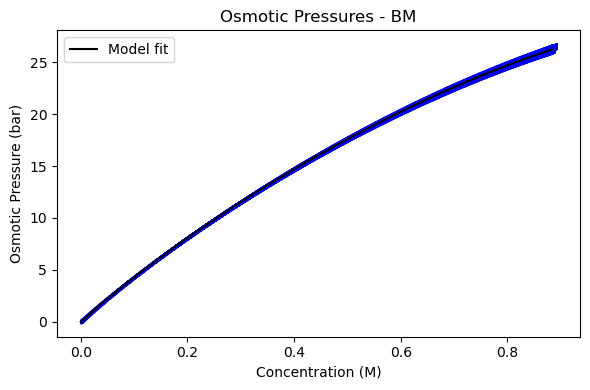

In [52]:
ocs,ops,opt_oc,opt_op=scatplots(bparams,bcs,c_opt_sparse_all,full_opt,'BM')

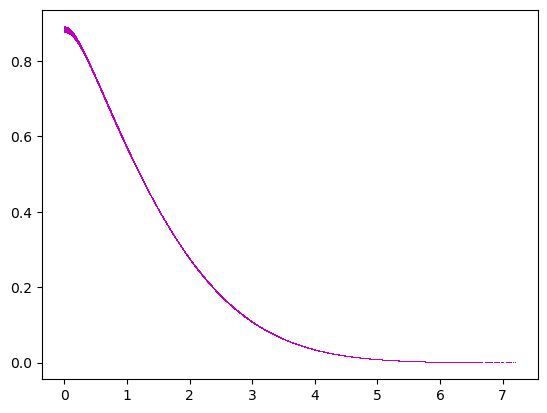

Average maximum concentration 0.9M


In [53]:
maxconcs=[]
for i in range(len(bcs)):    
    plt.scatter(zsparse_all,bcs[i],s=0.1,lw=0.1,c='m')
    maxconcs.append(bcs[i][0])
plt.show()

av_maxconcs=np.mean(maxconcs)
print(f'Average maximum concentration {av_maxconcs:.1f}M')

## Results

## Getting and saving results

In [54]:
def calculate_osmotic_properties(target_values,percentiles_oc,percentiles_op,c_opt_sparse_all,opt_oc,opt_op):
    """
    Calculates osmotic coefficient and osmotic pressure properties for a list of target values.

    Parameters:
        target_values (list): List of concentration values to analyze.

    Returns:
        dict: Dictionary containing osmotic coefficient, osmotic pressure, and their respective errors.
    """

    results = {
        'osmotic_coefficient': [],
        'osmotic_coefficient_error': [],
        'osmotic_pressure': [],
        'osmotic_pressure_error': []
    }

    for target_value in target_values:
        closest_index, closest_value = find_closest(c_opt_sparse_all, target_value)
        
        # Osmotic coefficient calculations
        y_oc = opt_oc[closest_index]
        uncertainty_oc = (percentiles_oc["95"][1][closest_index] - percentiles_oc["95"][0][closest_index]) / 2
        results['osmotic_coefficient'].append(float(y_oc))
        results['osmotic_coefficient_error'].append(float(uncertainty_oc))

        # Osmotic pressure calculations
        y_op = opt_op[closest_index]
        uncertainty_op = (percentiles_op["95"][1][closest_index] - percentiles_op["95"][0][closest_index]) / 2
        results['osmotic_pressure'].append(float(y_op))
        results['osmotic_pressure_error'].append(float(uncertainty_op))
        
        print(f"Closest to {target_value:.2f}: {closest_value:.2f} at index {closest_index}, "
              f"OC: {y_oc:.3f} ± {uncertainty_oc:.3f},"
              f"OP: {y_op:.3f} ± {uncertainty_op:.3f}")

    return results


In [55]:
bounds = {
    "95": {"lower": 2.5, "upper": 97.5},
    "1s": {"lower": 16, "upper": 84}
}

# Compute percentile bounds
percentiles_oc = {
    key: np.percentile(ocs, [bounds[key]["lower"], bounds[key]["upper"]], axis=0)
    for key in bounds
}
percentiles_op = {
    key: np.percentile(ops, [bounds[key]["lower"], bounds[key]["upper"]], axis=0)
    for key in bounds
}

In [56]:
osmotic_results=calculate_osmotic_properties(exp_concs,percentiles_oc,percentiles_op,c_opt_sparse_all,opt_oc,opt_op)

Closest to 0.10: 0.10 at index 5702, OC: 0.863 ± 0.001,OP: 4.304 ± 0.030
Closest to 0.20: 0.20 at index 4391, OC: 0.811 ± 0.002,OP: 8.050 ± 0.051
Closest to 0.30: 0.30 at index 3518, OC: 0.772 ± 0.003,OP: 11.434 ± 0.068
Closest to 0.40: 0.39 at index 2827, OC: 0.738 ± 0.004,OP: 14.543 ± 0.080
Closest to 0.49: 0.49 at index 2231, OC: 0.707 ± 0.005,OP: 17.420 ± 0.098
Closest to 0.59: 0.59 at index 1706, OC: 0.678 ± 0.006,OP: 20.002 ± 0.118
Closest to 0.69: 0.69 at index 1218, OC: 0.650 ± 0.006,OP: 22.370 ± 0.147
Closest to 0.79: 0.79 at index 751, OC: 0.623 ± 0.006,OP: 24.412 ± 0.191
Closest to 0.88: 0.88 at index 82, OC: 0.595 ± 0.006,OP: 26.200 ± 0.295
Closest to 0.98: 0.88 at index 0, OC: 0.595 ± 0.006,OP: 26.229 ± 0.295
Closest to 1.17: 0.88 at index 0, OC: 0.595 ± 0.006,OP: 26.229 ± 0.295
Closest to 1.36: 0.88 at index 0, OC: 0.595 ± 0.006,OP: 26.229 ± 0.295
Closest to 1.54: 0.88 at index 0, OC: 0.595 ± 0.006,OP: 26.229 ± 0.295
Closest to 1.91: 0.88 at index 0, OC: 0.595 ± 0.006,OP:

Save results

In [57]:
# Process and write to JSON
json_results = json.dumps(format_dict(osmotic_results), indent=4)

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'
    frdir = f'{rdir}_{mi}m'

    with open(f"{frdir}/{ion1}{ion2}_final_results_{mi}m.json", "w") as outfile:
        outfile.write(json_results)

    # Write results to CSV
    csv_filename = f"{frdir}/{ion1}{ion2}_final_results_{mi}m.csv"
    with open(csv_filename, mode='w', newline='') as csvfile:
        fieldnames = ["Molality", "Osmotic Coefficient", "Osmotic Coefficient Error", "Osmotic Pressure", "Osmotic Pressure Error"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for i, molality in enumerate(salt_dict[f"{ion1}{ion2}"].keys()):
            writer.writerow({
                "Molality": molality.split()[1],  # Extract molality value
                "Osmotic Coefficient": osmotic_results['osmotic_coefficient'][i],
                "Osmotic Coefficient Error": osmotic_results["osmotic_coefficient_error"][i],
                "Osmotic Pressure": osmotic_results["osmotic_pressure"][i],
                "Osmotic Pressure Error": osmotic_results["osmotic_pressure_error"][i]
            })

    print(f"Results saved to {csv_filename}")

Results saved to HP_MgCl_OPC3/result_files_05m/MgCl_final_results_05m.csv


## Plotting Results

In [58]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

Osmotic Coefficient vs Concentration Plot

In [59]:
N_i

34

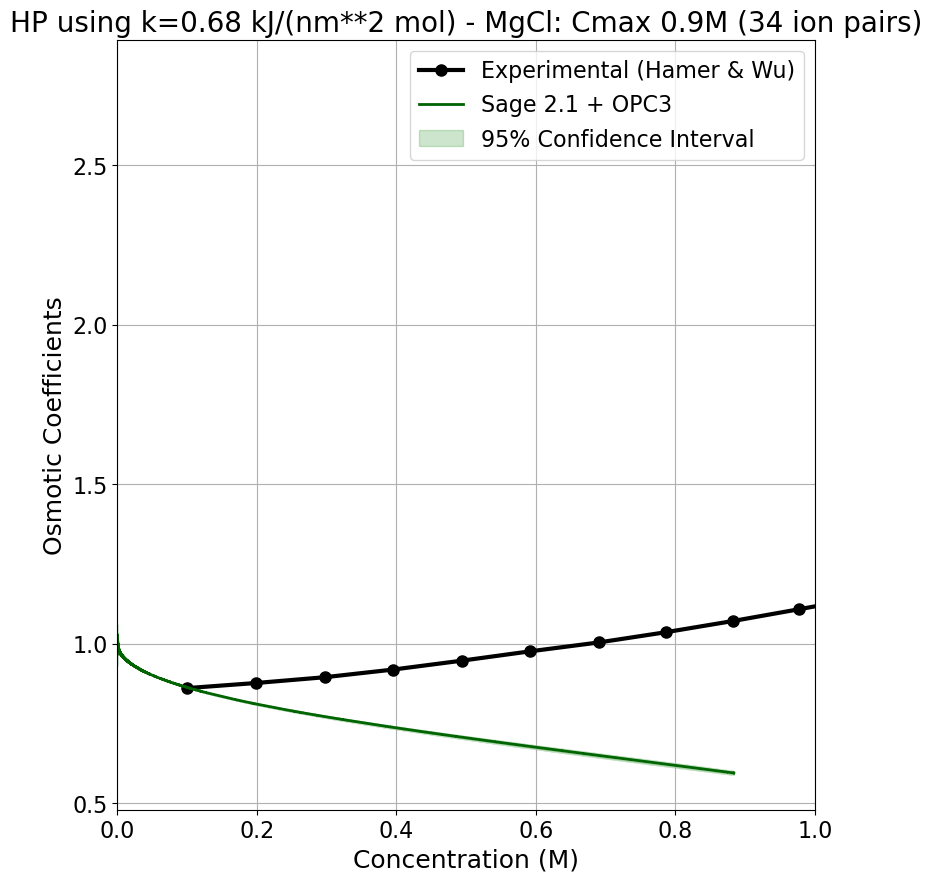

In [60]:
# Extract percentile-based confidence intervals
lower_bound_95_oc, upper_bound_95_oc = percentiles_oc["95"]
# lower_bound_1s_oc, upper_bound_1s_oc = percentiles_oc["1s"]

# Plot osmotic coefficients vs concentration
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs, yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Harmonic Potential data of osmotic coefficients with 95% confidence interval
plt.plot(c_opt_sparse_all, opt_oc, lw=2, label=f'{ff_used}', color='darkgreen')
plt.fill_between(c_opt_sparse_all, lower_bound_95_oc, upper_bound_95_oc, color='g', alpha=0.2, label='95% Confidence Interval')

plt.xlim(0,molalities[-1]+0.5)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Coefficients', fontsize=MEDIUM_SIZE)
plt.legend()
plt.grid()
plt.title(f'HP using k={k} - {ion1}{ion2}: Cmax {av_maxconcs:.1f}M ({N_i} ion pairs)', fontsize=BIGGER_SIZE)
plt.savefig(f'{frdir}/{ion1}{ion2}_oc.png')
plt.show()

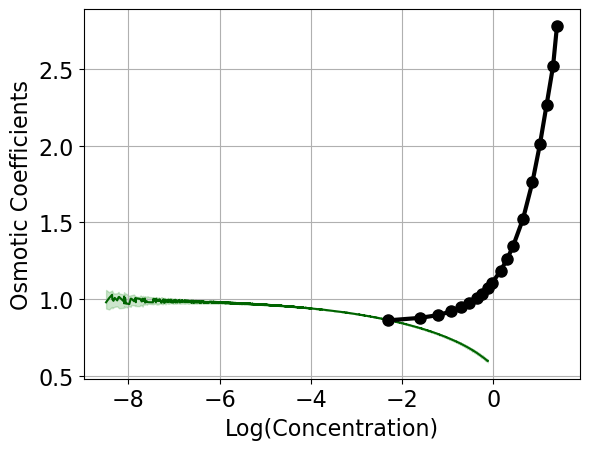

In [61]:
# osmotic coefficients vs ln of concentration
plt.plot(np.log(c_opt_sparse_all), opt_oc, label='Mean Profile', color='darkgreen')
plt.fill_between(np.log(c_opt_sparse_all), lower_bound_95_oc, upper_bound_95_oc, color='g', alpha=0.2, label='95% Confidence Interval')

# ln of experimental data
plt.plot(np.log(exp_concs), yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.grid()
plt.show()

Osmotic Pressure vs Concentration Plot

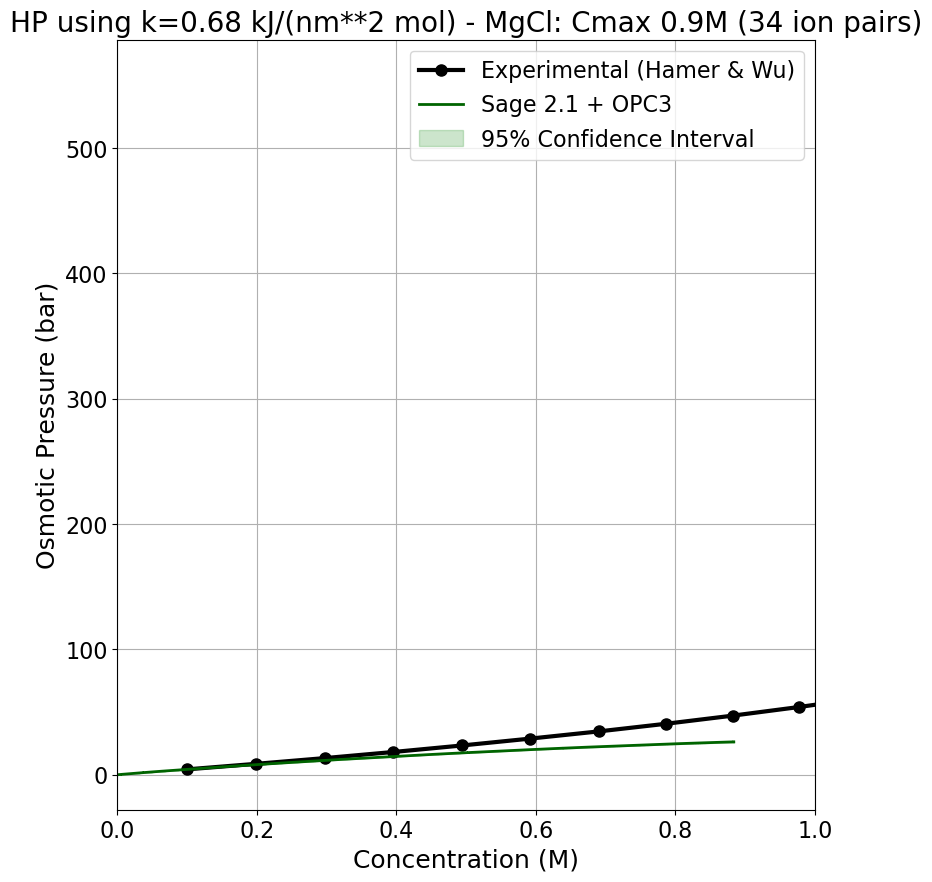

In [62]:
lower_bound_95_op, upper_bound_95_op = percentiles_op["95"]
lower_bound_1s_op, upper_bound_1s_op = percentiles_op["1s"]

# Plot osmotic pressure vs concentration
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs, yexpOP, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Harmonic Potential data of osmotic pressure with 95% confidence interval
plt.plot(c_opt_sparse_all, opt_op, lw=2, label=f'{ff_used}', color='darkgreen')
plt.fill_between(c_opt_sparse_all, lower_bound_95_op, upper_bound_95_op, color='g', alpha=0.2, label='95% Confidence Interval')

plt.xlim(0,molalities[-1]+0.5)
plt.title(f'HP using k={k} - {ion1}{ion2}: Cmax {av_maxconcs:.1f}M ({N_i} ion pairs)', fontsize=BIGGER_SIZE)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Pressure (bar)', fontsize=MEDIUM_SIZE)
plt.legend()
plt.grid()
plt.savefig(f'{frdir}/{ion1}{ion2}_op.png')
plt.show()